In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import clip
from PIL import Image
from PIL import ImageOps
import cv2

import numpy as np
import pandas as pd
import copy
import os
import glob

import datetime as dt
import time
from timethis import timethis
import subprocess
from common_params import parent_directory_images, parent_directory_url_csvs

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
# define the list of categories
# this needs to be selected carefully, similar to prompt engineering for LLMs
categories = [
    'car exterior',
    'car interior',
    'car key',
    # 'dealership banner',
    'advertisement',
    # 'warranty',
    'dashboard',
    'wireless charger',
    'engine bay',
    'gauge cluster',
    'gear selector',
    'infotainment/navigation screen',
    'moonroof',
    'paperwork',
    'steering wheel',
    'wheels closeup'
]
categories = sorted(set(categories))

CAR_EXTERIOR_THRESHOLD = 0.7



In [4]:
def create_image_files_df():
    '''
    File naming example '/Users/levgolod/Projects/car_classifier/data/autotrader/vehicle_images/make-bmw/model-3-series/vehicle_id-701932606/20f1aa5ef85b48f7ac676a1e82147582.jpg',

    :return:
    '''
    parent_directory_images
    image_files = sorted(glob.glob(parent_directory_images + '**/*.jpg', recursive=True))
    print(len(image_files))
    # image_files = image_files[:4]
    df = pd.DataFrame({'filepath': image_files})
    df['filename'] = df['filepath'].apply(lambda x: os.path.basename(x))
    df['make'] = df['filepath'].apply(lambda x: x.split('/')[8].replace('make-',''))
    df['model'] = df['filepath'].apply(lambda x: x.split('/')[9].replace('model-',''))
    df['vehicle_id'] = df['filepath'].apply(lambda x: x.split('/')[10].replace('vehicle_id-',''))
    return df


def get_predicted_categories_clip(image_path:str, categories:list)->dict:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text_inputs = clip.tokenize(categories).to(device)

    # Predict category
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
        probs = (image_features @ text_features.T).softmax(dim=-1)

    probs_w_categories = pd.Series(dict(zip(categories, np.array(probs)[0]))).sort_values(ascending=False)
    return probs_w_categories


def categorize_and_plot(image_path, categories):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display

    predicted_categories_all = get_predicted_categories_clip(image_path, categories)
    predictions = dict(predicted_categories_all.head(3))


    # Convert image to writable format
    overlay = image.copy()

    # Define text box properties
    x, y, w, h = 10, 10, 350, 80  # Top-right position
    alpha = 0.9  # Transparency level

    # Draw semi-transparent rectangle
    cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 0, 0), -1)  # Black box
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)  # Blend with original image

    # Add text on top of the rectangle
    y_offset = y + 20
    for label, prob in predictions.items():
        text = f"{label}: {int(prob*100):.0f}%"
        cv2.putText(image, text, (x + 10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        y_offset += 20  # Line spacing

    # Display the image
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.show()
    return plt

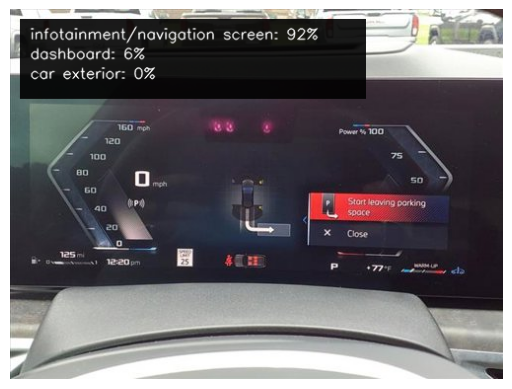

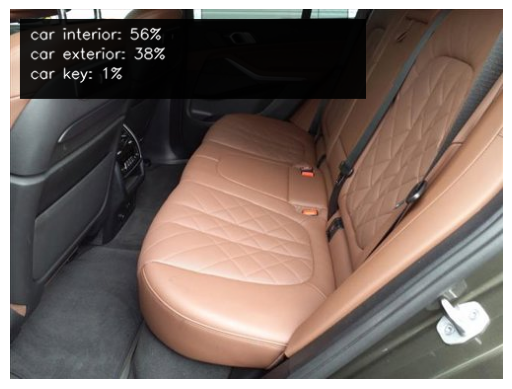

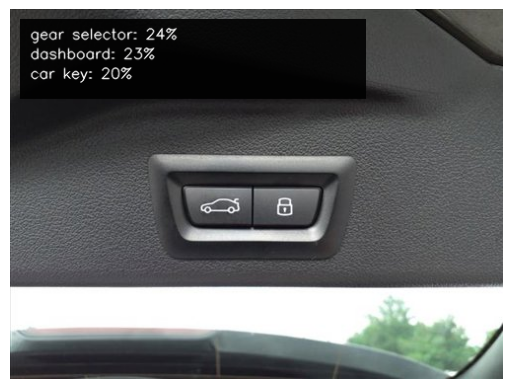

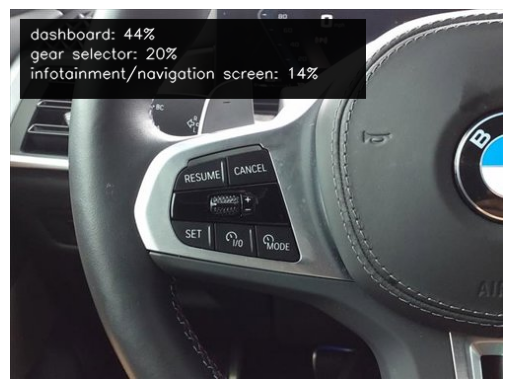

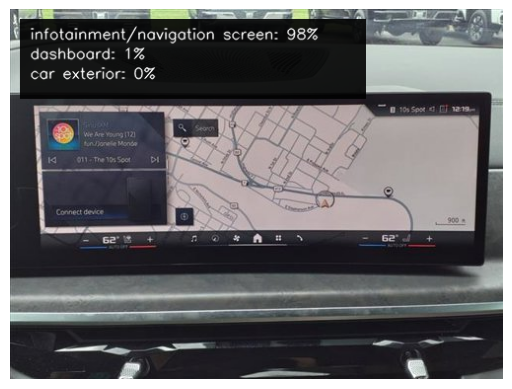

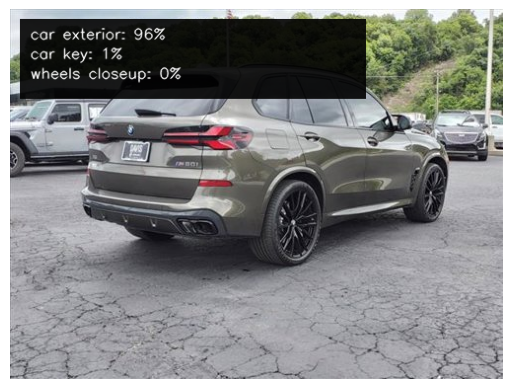

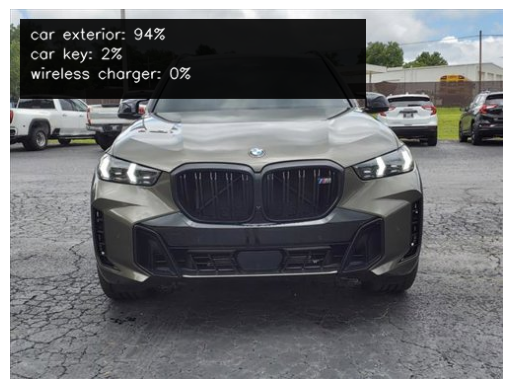

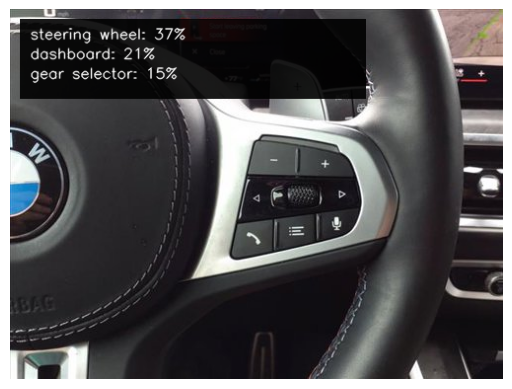

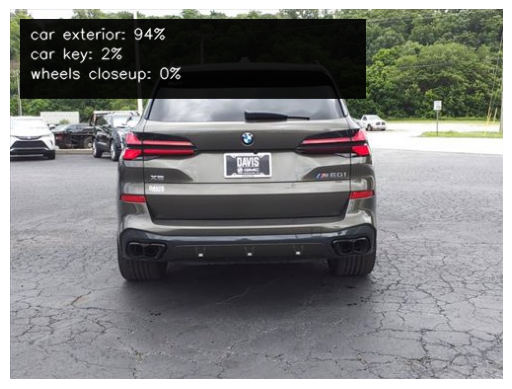

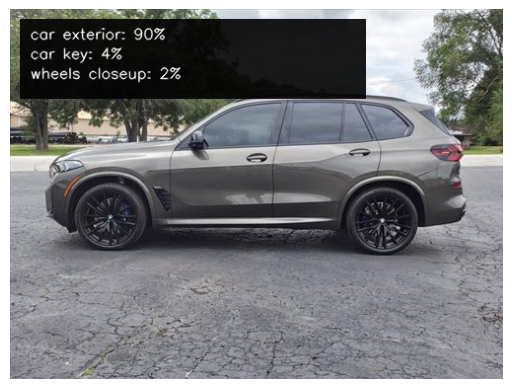

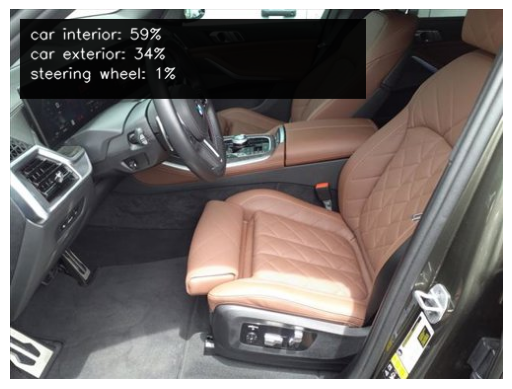

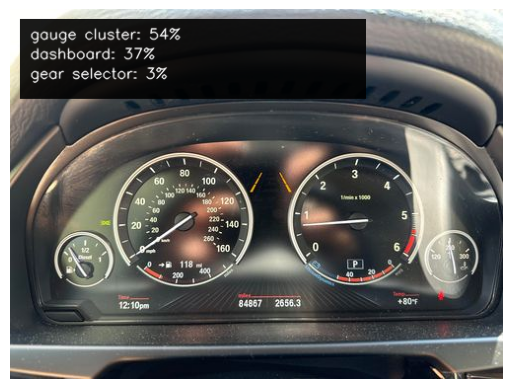

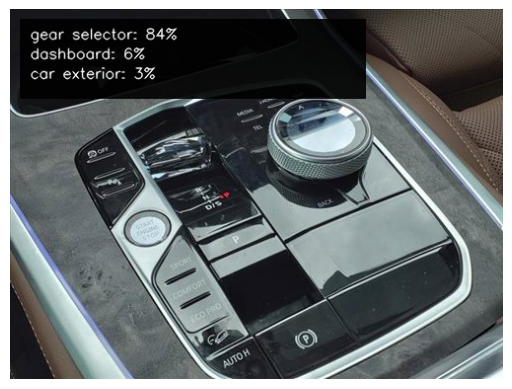

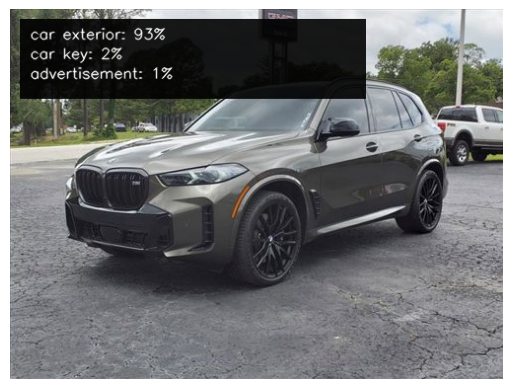

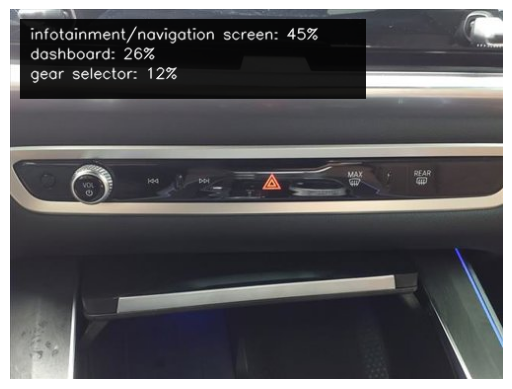

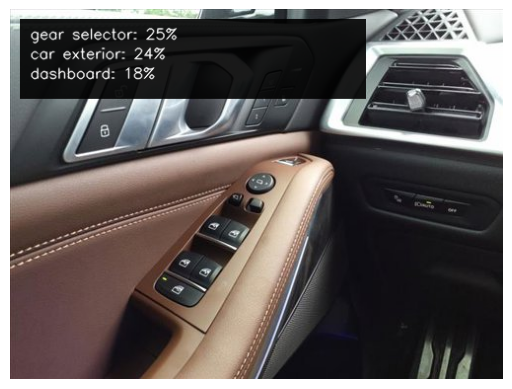

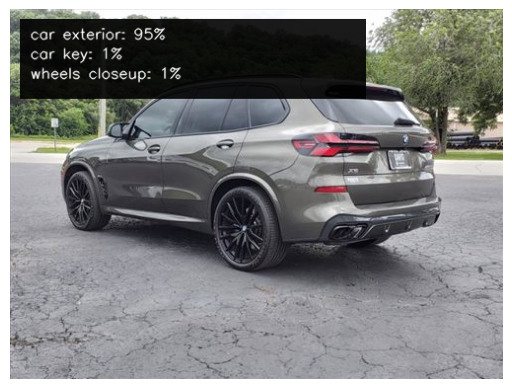

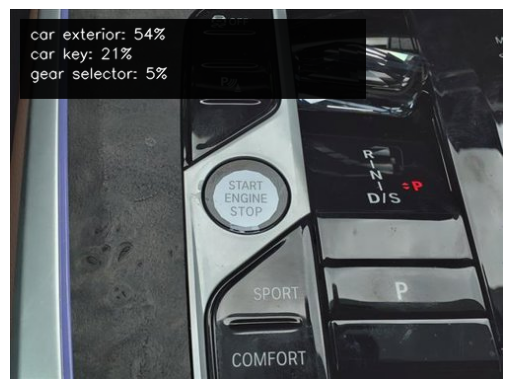

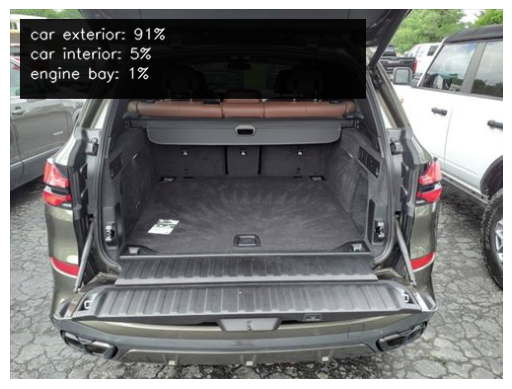

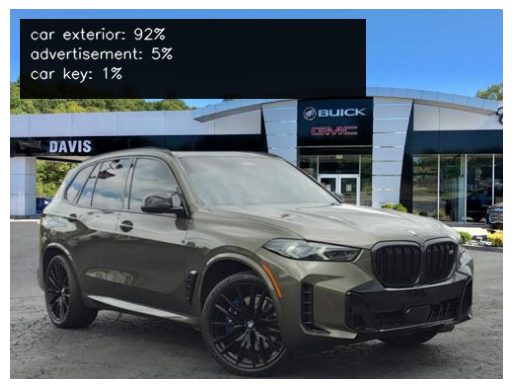

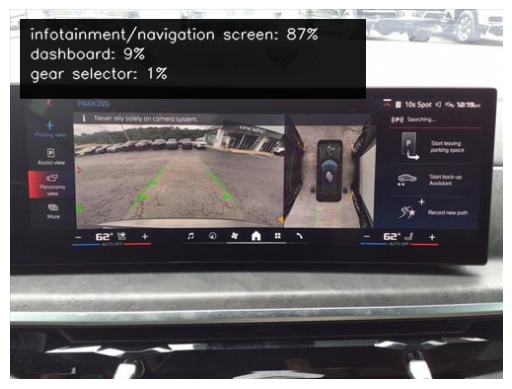

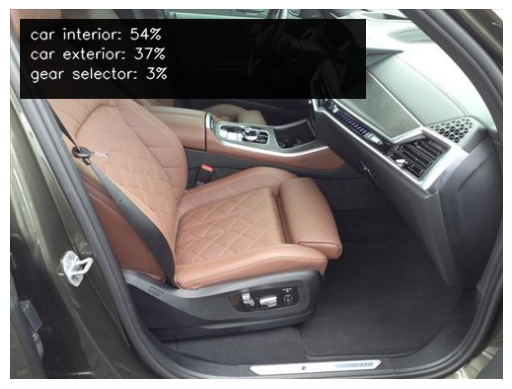

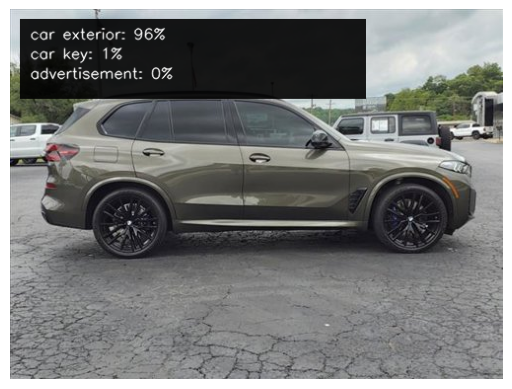

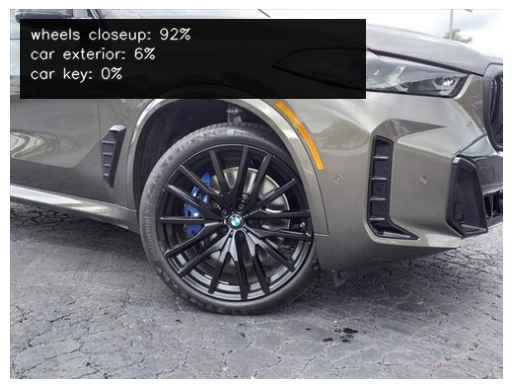

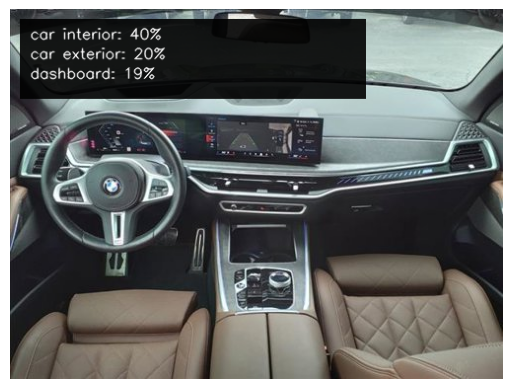

[<module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Projects/venv3/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/Users/levgolod/Proje

In [5]:
# demonstrate that CLIP does a reasonable job
files=sorted(glob.glob('/Users/levgolod/Projects/car_classifier/data/autotrader/vehicle_images/make-bmw/model-x5/vehicle_id-716406739/*.jpg'))
files

# categorize_and_plot(image_path=files[0], categories=categories)
list(map(
    lambda x: categorize_and_plot(x, categories),
    files
))

In [6]:

image_files_df = create_image_files_df()
image_files_df = image_files_df.drop_duplicates(subset=['filepath'])
image_files_df.sort_values(['make','model','vehicle_id','filename'],inplace=True)
image_files_df.reset_index(inplace=True,drop=True)
image_files_df.head()


25947


filepath  \
0  /Users/levgolod/Projects/car_classifier/data/a...   
1  /Users/levgolod/Projects/car_classifier/data/a...   
2  /Users/levgolod/Projects/car_classifier/data/a...   
3  /Users/levgolod/Projects/car_classifier/data/a...   
4  /Users/levgolod/Projects/car_classifier/data/a...   

                               filename make     model vehicle_id  
0  20f1aa5ef85b48f7ac676a1e82147582.jpg  bmw  3-series  701932606  
1  376e2b73f7e04c0abb53dbed174a7bc8.jpg  bmw  3-series  701932606  
2  6f01890791f24dd69ccc70aff90cd73c.jpg  bmw  3-series  701932606  
3  ac2d692d18f64c6b9eb4835d24bd42eb.jpg  bmw  3-series  701932606  
4  b4ade0a7c1c5426496acf7b3d45eb8d5.jpg  bmw  3-series  701932606

In [8]:
i=2
probs_dict = dict(get_predicted_categories_clip(
    image_path= image_files_df.loc[i, 'filepath'],
    categories=categories
))
is_car_exterior = probs_dict.get('car exterior',0) >= CAR_EXTERIOR_THRESHOLD
is_car_exterior

False

In [ ]:

df2=image_files_df.head(25).copy(deep=True)
df2=image_files_df.copy(deep=True)

output_filename = f'{parent_directory_url_csvs}df_clip_categorize.csv'


iterprint = 10
for i in df2.index:
    if i % iterprint==0:
        message =\
f'''###########################################################
### Begin processing {i} of {len(image_files_df)} | {dt.datetime.now().replace(microsecond=0)}
###########################################################'''
        print(message) # second
        timestamp = int(time.time())
        filename_checkpoint = output_filename + f'-checkpoint.{timestamp}'
        df2.loc[:i+1, ].to_csv(filename_checkpoint, index=False)

    probs = get_predicted_categories_clip(
        image_path= image_files_df.loc[i, 'filepath'],
        categories=categories
    )
    top_category  = probs.head(1).index[0]
    probs_dict = dict(probs)
    is_car_exterior = probs_dict.get('car exterior',0) >= CAR_EXTERIOR_THRESHOLD
    df2.loc[i, 'is_car_exterior']=int(is_car_exterior)
    df2.loc[i, 'top_category']=str(top_category)
    df2.loc[i, 'probs_dict']=str(probs_dict)


df2.to_csv(output_filename, index=False)



###########################################################
### Begin processing 0 of 25947 | 2025-02-17 18:35:21
###########################################################
###########################################################
### Begin processing 10 of 25947 | 2025-02-17 18:35:32
###########################################################
###########################################################
### Begin processing 20 of 25947 | 2025-02-17 18:35:43
###########################################################
###########################################################
### Begin processing 30 of 25947 | 2025-02-17 18:35:53
###########################################################


In [ ]:
# probs = get_predicted_categories_clip(
#         image_path= image_files_df.loc[i, 'filepath'],
#         categories=categories
#     )
# probs
# top_category  = probs.head(1).index[0]
# top_category

In [ ]:
df3 = pd.read_csv(output_filename)
df3

In [ ]:
output_filename
subprocess.call(f' wc -l `find {os.path.dirname(output_filename)} -type f -name "{os.path.basename(output_filename)}-*" | sort `   ', shell=True)


# !wc -l "{$output_filename}"
# !echo "${$output_filename}"